# Tools for Experiments Overview

## Introduction

This notebook is aiming to broadly introduce all the major components of the toolsforexperiments suite.
the document is currently still work in progress, but already a decent starting point for a few things.

- Prerequisites: 
  - you should know the qcodes basics
  - have a look at the 'dummy_measurement_without_server' example before

## Imports

We need to have some common packages installed, and also need qcodes and plottr.
Refer to the official qcodes documentation for how to set up the right environment.

Plottr can be installed from pip or conda, or from github.

instrumentserver needs to be installed from github (and preferably using `pip install -e`).

In [1]:
from pprint import pprint
import time

import numpy as np
from matplotlib import pyplot as plt
import h5py

from qcodes import Instrument, Station, find_or_create_instrument
from plottr.data import datadict_storage as dds, datadict as dd


from labcore.measurement import *
from labcore.ddh5 import run_and_save_sweep


## The instrument server

The role of the instrument server is to manage access to instruments (both real and virtual), so they can be used from multiple processes. 
It's not strictly necessary to use it, and its designed such that using instruments through the server can be used also to talk to instruments that are instantiated directly.

Start the instrumentserver from the commandline (in an env't that has qcodes and the instrumentserver package installed) in a directory that will be the working directory for the server.

```bash
    $ instrumentserver
```

Because no instruments are instantiated at this point, we get an empty window reflecting the blank qcodes station living inside the server.
We can already create a client in this notebook that connects to the instrumentserver:

In [2]:
from instrumentserver.client import Client as InstrumentClient
cli = InstrumentClient() # connect to default host (localhost) and default port (5555)

We will now see how we can make use of the fact that we can talk to the instrumentserver from multiple processes. 
We'll create a virtual instrument (something with no direct counterpart on the hardware side) that allows us to manage arbitrary experiment parameters that we can access across the setup (a fancy way to keep track of important variables). After that, we'll set up some dummy instruments and perform some fake data acquisition with them.

### Parameter manager

We'll first launch the *parameter manager*. Because it has a dedicated GUI we run it as a standalone program. 
From a command line prompt we can launch it separately (again, make sure to do this within an env't that has the instrumentserver package installed):

```bash
    $ instrumentserver-param-manager
```

We'll simply get an empty window now.
The bottom of the window allows us to add arbitrary parameters and values, where dots serve as hierarchy separators (like objects and their children in python).
Let's add a few parameters, let's say `qubit.frequency`, `qubit.pipulse.len`, `qubit.pipulse.amp` and give them some arbitrary values.
We'll see something like this:

![Parameter manager window](figures/parammgr.png)

Because parameters live in the instrumentserver we can access the values here by creating a 'Proxy' instrument that forwards all requests to the 'real' instrument.

In [3]:
params = cli.get_instrument('parameter_manager') # 'parameter-=_manager' is the name the startup script gives the instrument by default

# simply output the value of the pi pulse length:
params.qubit.pipulse.len()

40

The different clients (such as the one in the notebook kernel and the one of the GUI) should stay in sync automatically.
If we update a value from there, the GUI will display the change right away.
In turn, calling a parameter get function should always return the most recent value the server has.

In [4]:
# after executing, the change is immediately visible in the GUI.
params.qubit.pipulse.len(100)

In [5]:
# if we change the value in the GUI, this will return the new value.
params.qubit.pipulse.len()

100

The same goes for adding new parameters after all clients are connected.
We can add new parameters very easily from any client.
The GUI should update automatically once we add something here.

In [6]:
# this will only be available in the GUI after pressing the refresh button.
params.add_parameter('qubit.anharmonicity', initial_value=-150.0, unit='MHz')

If we add a parameter in the instrument GUI (let's say: `resonator.frequency`), we can immediately access it from within the notebook.
Note, however, that autocomplete will not work right away (the client in the notebook needs to refresh, which only happens once we try to execute the command).

In [7]:
params.resonator.frequency()

3

We can also remove parameters directly from the code:

In [8]:
params.remove_parameter('qubit.pipulse.len')

After runnning this line we can see that the paremeter disappeared from the parameter manager.

### Adding instruments to the server

When using 'vanilla' qcodes, we would simply create a qcodes station in our working kernel, then add instruments by instantiating the corresponding driver classes.
When using the instrumentserver to manage our instrument instances, we instead want to instantiate inside the station that the server runs.

As an example, we will add a dummy instrument that behaves like a vector network analyzer and simulates a resonator response.
Only the server will instantiate it, so instead of importing the driver, we pass the import path (of course, needs to be known in the environment that the server is running in).

In [9]:
vna = cli.create_instrument(
    'instrumentserver.testing.dummy_instruments.rf.ResonatorResponse', # the path to the driver; must be importable for the server program.
    'vna',  # this is the name of the instrument in the server station
    f0=6.789e9,  # the resonance frequency of the mock resonator
    df=10e6,  # the linewidth
)

In [10]:
# setting some reasonable values
vna.start_frequency(6.089e9)
vna.stop_frequency(7.089e9)
vna.npoints(1201)
vna.bandwidth(1e4)
vna.power(-50)

### Using the parameter manager in measurements

Refer to [measurement_notebook](https://github.com/toolsforexperiments/recipes/blob/master/dummy_measurement_without_server/measurement_notebook.ipynb) for a more in depth guide example of the measurement we are taking. 

The idea here is simple: by using parameters from the parameter manager we don't need to store configuration variables in measurement scripts, and can run functions using user-changeable parameters without having to pass variables. 
We illustrate this with an artificial, but also not too unrealistic dummy case: 
Assume we often want to sweep a flux (for instance for tuning a resonator) a small range around a given setpoint that can change.
Not having to keep track of that setpoint throughout scripts can make life a bit easier (and will hopefully lead to fewer mistakes).

First, lets instantiate the virtual flux controller, and define the measurement function:

In [11]:
fluxctrl = cli.create_instrument(
    instrument_class='instrumentserver.testing.dummy_instruments.rf.FluxControl',
    name='fluxctrl',
    resonator_instrument='vna'
)

def sweep_flux(sweep_range=0.5, nsteps=51):
    flux, frequency, s11 = [], [], []
    
    vna.resonator_linewidth(10e6)
    vna.resonator_frequency(params.resonator.frequency() * 1e9)
    f0 = params.resonator.flux()-sweep_range/2.
    f1 = params.resonator.flux()+sweep_range/2.
    for f in np.linspace(f0, f1, nsteps):
        fluxctrl.flux(f)
        flux.append(f)
        frequency.append(vna.frequency())
        s11.append(vna.data())

    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.imshow(np.angle(np.array(s11)), aspect='auto', origin='lower', 
              extent=[frequency[0].min(), frequency[0].max(), f0, f1])

Let's add the parameter we want to control, ``resonator.flux``, via the GUI.
After that we can measure by setting parameters in the GUI, rather than typing them explicitly.

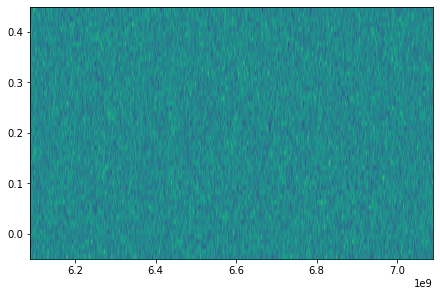

In [12]:
# change resonator frequency or flux in the gui, and re-run to see the change.
sweep_flux()

It is of course clear that in such a simple experiment the Parameter Manager GUI provides only a limited amount of benefit.
However, once parameters are used across many different measurements, it can be very convenient to have it act as the central "single source of truth".

### Saving and recalling the state of the setup

Saving all current parameters in the instrumentserver to a file:

In [13]:
cli.paramsToFile('parameters.json')

We can also save the state by pressing the `Save to file` button in the top left of server GUI. 
We can also utilize the `Save parameters to file` button from the parameter manager GUI to only save the parameters of the manager and not the entire state of the station.

By default `paramsToFile` saves only the name and value of a parameter, but we can also save units, for example:

In [14]:
cli.paramsToFile('parameters-with-units.json', instrument='parameter_manager', attrs=['value', 'unit'])

Loading works similar:

In [15]:
cli.paramsFromFile('parameters.json')

We can save and recall also from the GUI.
The instrumentserver GUI allows saving/loading the state of all instruments using a default file in the working directory (``parameters.json``).
For more control we can use the API as shown above.

In addition, the parameter manager GUI also allows saving/restoring all its parameters from the GUI. It saves to a separate file in the current working directory from where the parameter manager was launched (``parameter_manager-<name_of_instrument>.json``) and includes the units.

### Logger and Dashboard

Specific guide on the logger and dasher TBD :)

## Plottr: data management and inspection

### General introduction

Plottr is a collection of tools that facilitate the correct saving, plotting and analisis of data.

### Simple Example on how to save data

In the following example we show to firstly declare the structure and metadata of the ``DataDict``, in this case we have two independent variabels (`x` and `y`) and a dependent variable (`z`) that depends on both of them.

In [16]:
# Declaring the structure of the DataDict.
data = dd.DataDict(
    x = dict(unit='A'),
    y = dict(unit='B'),
    z = dict(axes=['x', 'y']),
)

# We declare a few parameters used in the measurement
nrows = 100
file_name = "Example data"
DATADIR = './data'

# we start the context manager.
with dds.DDH5Writer(basedir=DATADIR, datadict=data, name=file_name) as writer:
    for n in range(nrows):
        writer.add_data(x=[n], 
                        y=np.linspace(0,1,11).reshape(1,-1),
                        z=np.random.rand(11).reshape(1,-1)
                        )
        time.sleep(1)

Data location:  ./data\2021-08-27\2021-08-27T155255_c0a0304f-Example data\data.ddh5


### How to open and plot data.

Running the command,

```bash
    $ plottr-monitr .\data
```

opens the monitr window inside the newly created data folder.Inside we can find all of the different measurements that are stored there labeled by day. If we go through the folder tree up to the DDH5 file created by the previous meausrement, on the right we will be able to see the metadata, which variable depends on what, the nuber of datapoints for each, etc) of our stored data.

![Monitr main window](figures/monitr_menu.png)

Doing a right click on data in the right window will open a popup saying "Plot data". 

![Selecting plot data](figures/selecting_plot_data.png)

By clicking on it, a new inspectr window opens up with a plot of the selected data. The window is by defualt divided into three different section. Bottom one being the plotted data. In it we can move around the data and zoom in and out of it. In the data selection window (top left) we can select which variable we want to plot in the case we have multiple variables in a single DDH5 file. In the dimension assignment window (top right) we can indicate what the independent varaibles should be in the plot (x or y axis, if we want them averaged, if we want to select a specific one, etc.).

![Inspectr window](figures/inspectr.png)


### How to view real time data.

To plot real time data we simply need to open the DDH5 file while the measurement is being executed and inspctr will update periodically every two seconds (you can specify this inverval of time in the 'Refresh interval' textbox in the toolbar.

### Nodes and Flowcharts

More advanced functionality for plottr can be created to spcify and automate analisys of data. To learn how to utilize it visit the [plottr documentation](../../plottr/concepts/nodes.rst).


## Labcore: tools for increasing efficiency.

### What is a sweep.

This is a very simple overview of what labcore does, for more information see [Sweep introduction](../../specialized_topics/labcore/Introduction_to_sweeping.ipynb).

Labcore is a tool that allows us to build end execute measurments in a simple and modular way. It does this by constructing a software object, the sweep, before anything gets executed. The sweep containes all the instructions on what to do and the structure of the data coming out it. This way one can plan and get information out of this object before anything happens. The construction of these sweep objects are extremely modular and flexible, allowing for an easy way re-using older code for specific tasks.

A sweep is an iterable, where each step in the iteration the sweep performs an action and returns some data, this data is in the form of a python dictionary and we call it **record**. 



### How to construct and run a simple sweep.

we construct a sweep out of parameters we want to sweep through and actions (usually functions) that need to happen in the measurement. This functions need to be annotated at some point to indicate what is the data that they produce. This can be done either by adding the decorator [recording](../../api/labcore/measurement/record.rst#labcore.measurement.record.recording) to a function that generates data or using the method [record_as](../../api/labcore/measurement/record.rst#labcore.measurement.record.record_as) when creating the sweep object.

In the following example we create a very simple sweep. Here we seep through the first item in the Sweep, (a veriable going from 0 to 4 created by the range funciton), and we first call func_1 passing the value of the variable as an arguement followed by func_2 again using the same value of the variable as an argument. For demonstration porpuses we use both the recording decorator and the record_as method to record the variables comming out of the functions.

In [2]:
@recording(
    independent('x', type='scalar', unit='')
)
def func_1(i):
    return i+1

def func_2(i):
    return i*2

sweep_object = Sweep(range(5), func_1, record_as(func_2, 'y'))


We can print the sweep object to see what it will do as well as seeing what data is going to generate.

In [3]:
print(sweep_object)

range(0, 5) >> func_1(i) as {x} >> func_2(i) as {y}
==> {x, y}


To execute a sweep we simply iterate through it inside a for loop.

In [4]:
for data in sweep_object:
    print(data)

{'x': 1, 'y': 0}
{'x': 2, 'y': 2}
{'x': 3, 'y': 4}
{'x': 4, 'y': 6}
{'x': 5, 'y': 8}


### Constructing a more complicated sweep.

Going a little bit deeper, this example follows a more realistic use-case. Lets say we have an experiment that requieres and inicial setup before we start the measurement, this needs to happens only once. After the initial setup we need to tune some paremeter and measure the new temperature and frequency trace. We want to repeat this experiment 3 times, while only performing the initial setup once.

We first need to create the individual functions that perform this actions (remembering to add the recording decorator to those function that return with data).

In [19]:
def initial_setup():
    print('Initiating the experiment.')

def tune_something(param):
    print(f'adjusting something in-situ using param={param}')

@recording(
    independent('frq', type='array', unit='Hz'), 
    dependent('phase', depends_on=['frq'], type='array', unit='rad')
)
def measure_frequency_trace(npoints=3):
    return [np.arange(1,npoints+1)*1e6, np.random.normal(size=npoints)]


@recording(dependent('temperature', unit='K'))
def measure_temperature():
    return np.random.normal(loc=0.1, scale=0.01)


After creating the individual parts for the sweep, we construct it using the `@`, `*`, and `+` operators. These operators allows us to construct a more complex sweep from smaller modular parts. The do the following:

- The matrix multiplication operator ``@`` creates a nested loop of sweeps (the outer loop are the repetitions, the inner loop the tuning of the parameter).
- The multiplication operator ``*`` is like an inner product (or zip), i.e., results in element-wise combination. That is, for each value of ``param`` we run ``measure_frequency_trace``.
- The addition operator ``+`` appends sweeps or actions to sweeps. I.e., ``measure_temperature`` is executed once after each ``param`` sweep.

The last tool we use to perform this measurament is the method [once()](../../api/labcore/measurement/sweep.rst#labcore.measurement.sweep.once). ``once`` creates a sweep that executes an instruction (passed as an argument) only one time.

In [20]:
sweep = (
    once(initial_setup) 
    + sweep_parameter('repetition', range(3))
    @ (sweep_parameter('param', range(3), tune_something)
       * measure_frequency_trace
       + measure_temperature)
)

Once we have the sweep constructed we can inspect how the data that produces will look like.

In [21]:
print(sweep.get_data_specs())

(repetition, param, frq, phase(repetition, param, frq), temperature(repetition))


Finally we can run the sweep and perform the measurement,

In [22]:
for data in sweep:
    print(data)

Initiating the experiment.
{'repetition': None, 'param': None, 'frq': None, 'phase': None, 'temperature': None}
adjusting something in-situ using param=0
{'repetition': 0, 'param': 0, 'frq': array([1000000., 2000000., 3000000.]), 'phase': array([-1.97495475, -0.78255971, -0.52350463]), 'temperature': None}
adjusting something in-situ using param=1
{'repetition': 0, 'param': 1, 'frq': array([1000000., 2000000., 3000000.]), 'phase': array([0.20918236, 0.5531535 , 0.10474238]), 'temperature': None}
adjusting something in-situ using param=2
{'repetition': 0, 'param': 2, 'frq': array([1000000., 2000000., 3000000.]), 'phase': array([0.04135622, 0.44846661, 0.27323325]), 'temperature': None}
{'repetition': 0, 'param': None, 'frq': None, 'phase': None, 'temperature': 0.09704561492419088}
adjusting something in-situ using param=0
{'repetition': 1, 'param': 0, 'frq': array([1000000., 2000000., 3000000.]), 'phase': array([-0.82095734, -1.14660191, -0.86743937]), 'temperature': None}
adjusting som

### Passing arguments to functions inside of a sweep

If we have a sweep that uses a function decorated with recording that can be passed arguments that change the measurement, we sometimes would like to repeat a sweep but change those arguments present. There are two different tools to do this. The first one, [using()](../../api/labcore/measurement/sweep.rst#labcore.measurement.sweep.PointerFunction.using), can be used when creating the sweep. To see this we create another example sweep. This sweep executes a function from a start point to an stop point with npoints in between and returns those points squared.

In [25]:
@recording(
    independent('x'),
    dependent('y', depends_on=['x']))
def squared(start=5, stop=-5, npoints=3):
    x = np.linspace(start, stop, npoints)
    y = x**2
    
    return x, y

sweep = sweep_parameter('repetition', range(3), squared.using(start=10, stop=-10, npoints=10))

for data in sweep:
    print(data)

{'repetition': 0, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11.11111111,  30.86419753,
        60.49382716, 100.        ])}
{'repetition': 1, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11.11111111,  30.86419753,
        60.49382716, 100.        ])}
{'repetition': 2, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11

As we can see the arguments used in the function squared are not the default.

If we want to change the arguments of a function after declaring it we can also do that by utilizing the sweep method, [set_options()](../../api/labcore/measurement/sweep.rst#labcore.measurement.sweep.Sweep.set_options). Passing any kwargs to ```set_options``` with the correct keyword we can change any argument of any function that a sweep uses.

In [26]:
sweep.set_options(start=2, stop=-2, npoints=3)

for data in sweep:
    print(data)

{'repetition': 0, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11.11111111,  30.86419753,
        60.49382716, 100.        ])}
{'repetition': 1, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11.11111111,  30.86419753,
        60.49382716, 100.        ])}
{'repetition': 2, 'x': array([ 10.        ,   7.77777778,   5.55555556,   3.33333333,
         1.11111111,  -1.11111111,  -3.33333333,  -5.55555556,
        -7.77777778, -10.        ]), 'y': array([100.        ,  60.49382716,  30.86419753,  11.11111111,
         1.2345679 ,   1.2345679 ,  11

### Example using sweep and saving data.

To save the data as we perfrom the measurement we can use the method [run_and_save_sweep()](../../api/labcore/ddh5.rst#labcore.ddh5.run_and_save_sweep) to do this. However because ``run_and_save_sweep`` follows the restrictions of the `DataDict` format, so we need every variable to have the same length. ``run_and_save_sweep`` also accepts any other object as kwargs, these objects will be also saved next to the data. If the object is a JSON compatible dictionary, the dictionary will be saved as a JSON file. If either the dictionary is not compatible with JSON or the object is not serializable, the object will be pickled and then saved. The files created will have their keyword as their name.

In [29]:
file_name = "Sweep data"
DATADIR = './data'

dict_example = {
    'extra': 'metadata',
    'state': True
}

run_and_save_sweep(sweep=sweep, data_dir=DATADIR, name=file_name, extra_metadata = dict_example)

Data location:  ./data\2021-09-17\2021-09-17T133023_5239fad5-Sweep data\data.ddh5
The measurement has finished successfully and all of the data has been saved.
